# Deploy the model and evaluate the metrics

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
import time

warnings.filterwarnings('ignore')

# 1. Load data
data = pd.read_csv('cleandata.csv')

# 2. Check and handle missing values
if data.isnull().sum().any():
    print("Handling missing values...")
    data = data.dropna()  # Drop rows with missing values. This can be modified as needed.

# 3. Check for class imbalance
class_counts = data['Output'].value_counts()
print("\nClass distribution:")
print(class_counts)

# 4. Separate features and target
X = data.drop(columns=['Output'])
y = data['Output']

# 5. Build an integrated pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=5, n_jobs=-1)),  # Use SMOTE with appropriate parameters
    ('poly', PolynomialFeatures(include_bias=False)),  # Create polynomial features
    ('scaler', StandardScaler()),  # Normalize features
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))  # Machine learning model
])

# 6. Set parameters for RandomizedSearchCV to reduce runtime
param_dist = {
    # SMOTE
    'smote__sampling_strategy': ['auto', 0.5],  # Sampling ratio
    'smote__k_neighbors': [3, 5],  # Number of neighbors for SMOTE

    # PolynomialFeatures
    'poly__degree': [1, 2],  # Interaction degree 1 and 2
    'poly__interaction_only': [True, False],  # Interaction only or include higher degrees

    # RandomForestClassifier
    'classifier__n_estimators': [100, 150],  # Number of trees
    'classifier__max_depth': [None, 10],  # Maximum depth
    'classifier__min_samples_split': [2, 5],  # Minimum samples to split
    'classifier__min_samples_leaf': [1, 2],  # Minimum samples per leaf
    'classifier__max_features': ['sqrt'],  # Maximum features for split
    'classifier__bootstrap': [True]  # Use bootstrap sampling or not
}

# 7. Record training and parameter search time
start_time = time.time()

# 8. Optimize the model with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  # Number of random searches
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# 9. Train the model with RandomizedSearchCV
random_search.fit(X, y)
best_pipeline = random_search.best_estimator_

# 10. Print best parameters from RandomizedSearchCV
print("\nBest Parameters from Randomized Search:", random_search.best_params_)

# 11. Split data into training and testing sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 12. Retrain the best model on the training set
best_pipeline.fit(X_train, y_train)

# 13. Predict on the test set
y_pred = best_pipeline.predict(X_test)

# 14. Evaluate the model
print("\nOverall Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 15. Evaluate using Cross-validation
cv_scores = cross_val_score(best_pipeline, X, y, cv=StratifiedKFold(n_splits=3), scoring='accuracy', n_jobs=-1)
print("\nAverage Accuracy from Cross-validation:", cv_scores.mean())

# 16. Print training and optimization time
end_time = time.time()
print("\nTraining and Optimization Time:", round(end_time - start_time, 2), "seconds")


Sự phân bố các lớp:
Output
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters from Randomized Search: {'smote__sampling_strategy': 'auto', 'smote__k_neighbors': 5, 'poly__interaction_only': False, 'poly__degree': 1, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None, 'classifier__bootstrap': True}

Độ chính xác tổng quát (Accuracy): 0.7548022598870057

Classification Report:
               precision    recall  f1-score   support

     Dropout       0.83      0.71      0.77       284
    Enrolled       0.46      0.53      0.49       159
    Graduate       0.83      0.86      0.85       442

    accuracy                           0.75       885
   macro avg       0.71      0.70      0.70       885
weighted avg       0.76      0.75      0.76       885


Confusion Matri

# Graphs

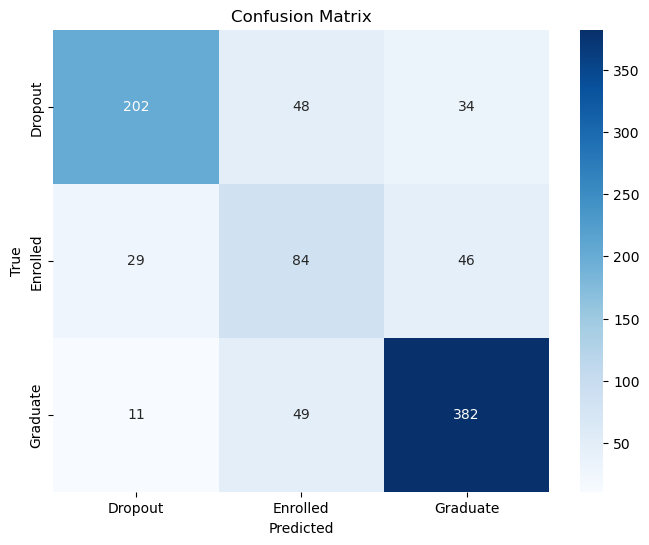

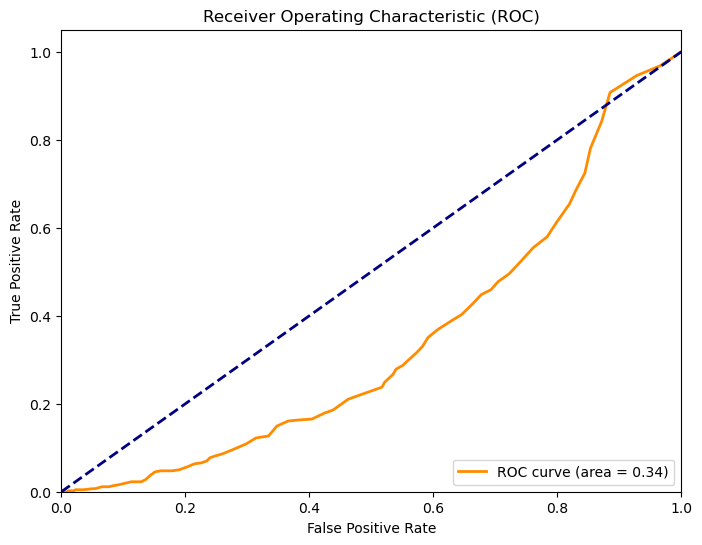

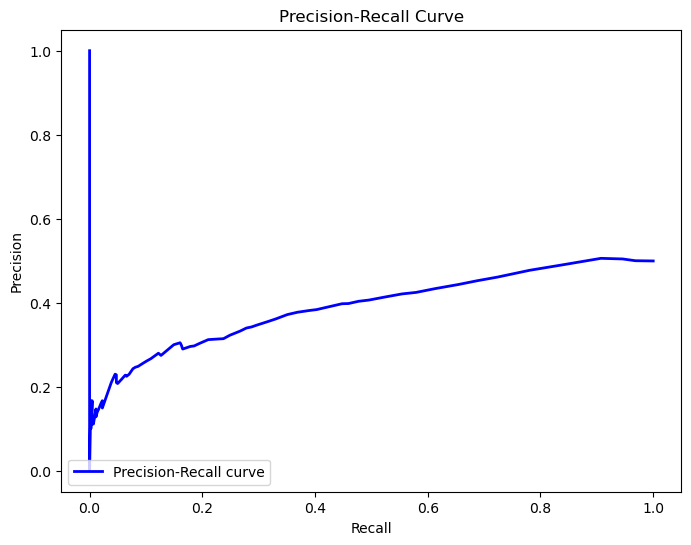

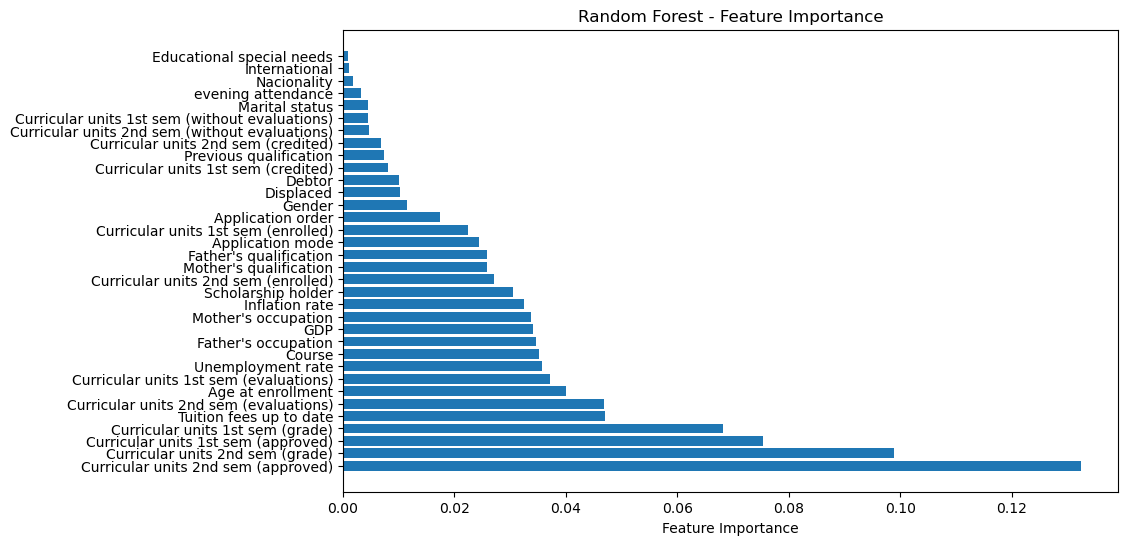

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Predictions on the test set
y_pred = best_pipeline.predict(X_test)
y_pred_prob = best_pipeline.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Dropout', 'Enrolled', 'Graduate'], 
            yticklabels=['Dropout', 'Enrolled', 'Graduate'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 2. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='Graduate')  # Adjust for the class of interest
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob, pos_label='Graduate')
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 4. Feature Importance (Random Forest)
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
features = X.columns

# Sort and plot
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), feature_importances[indices], align="center")
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

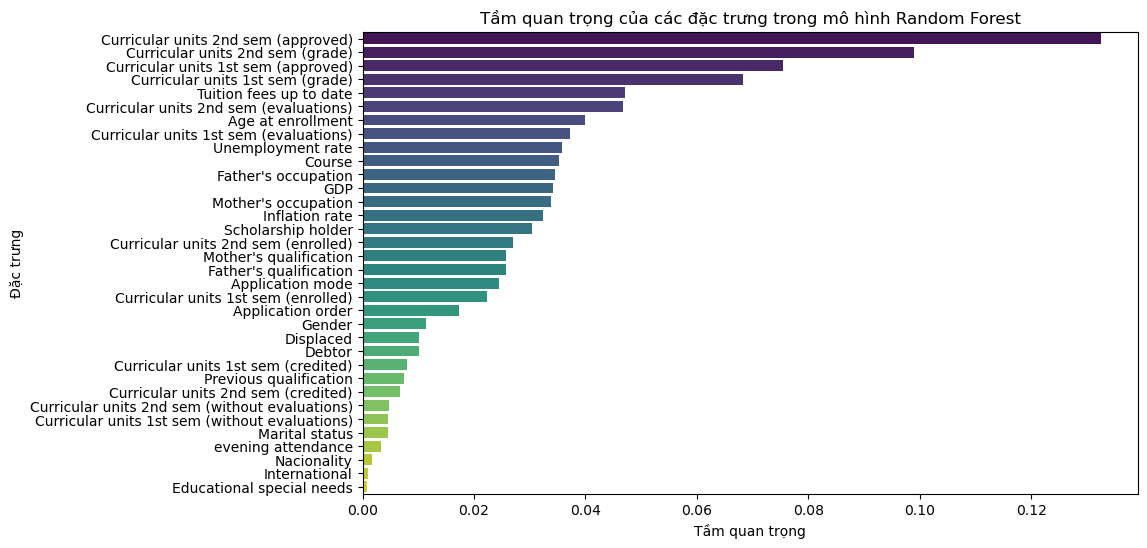

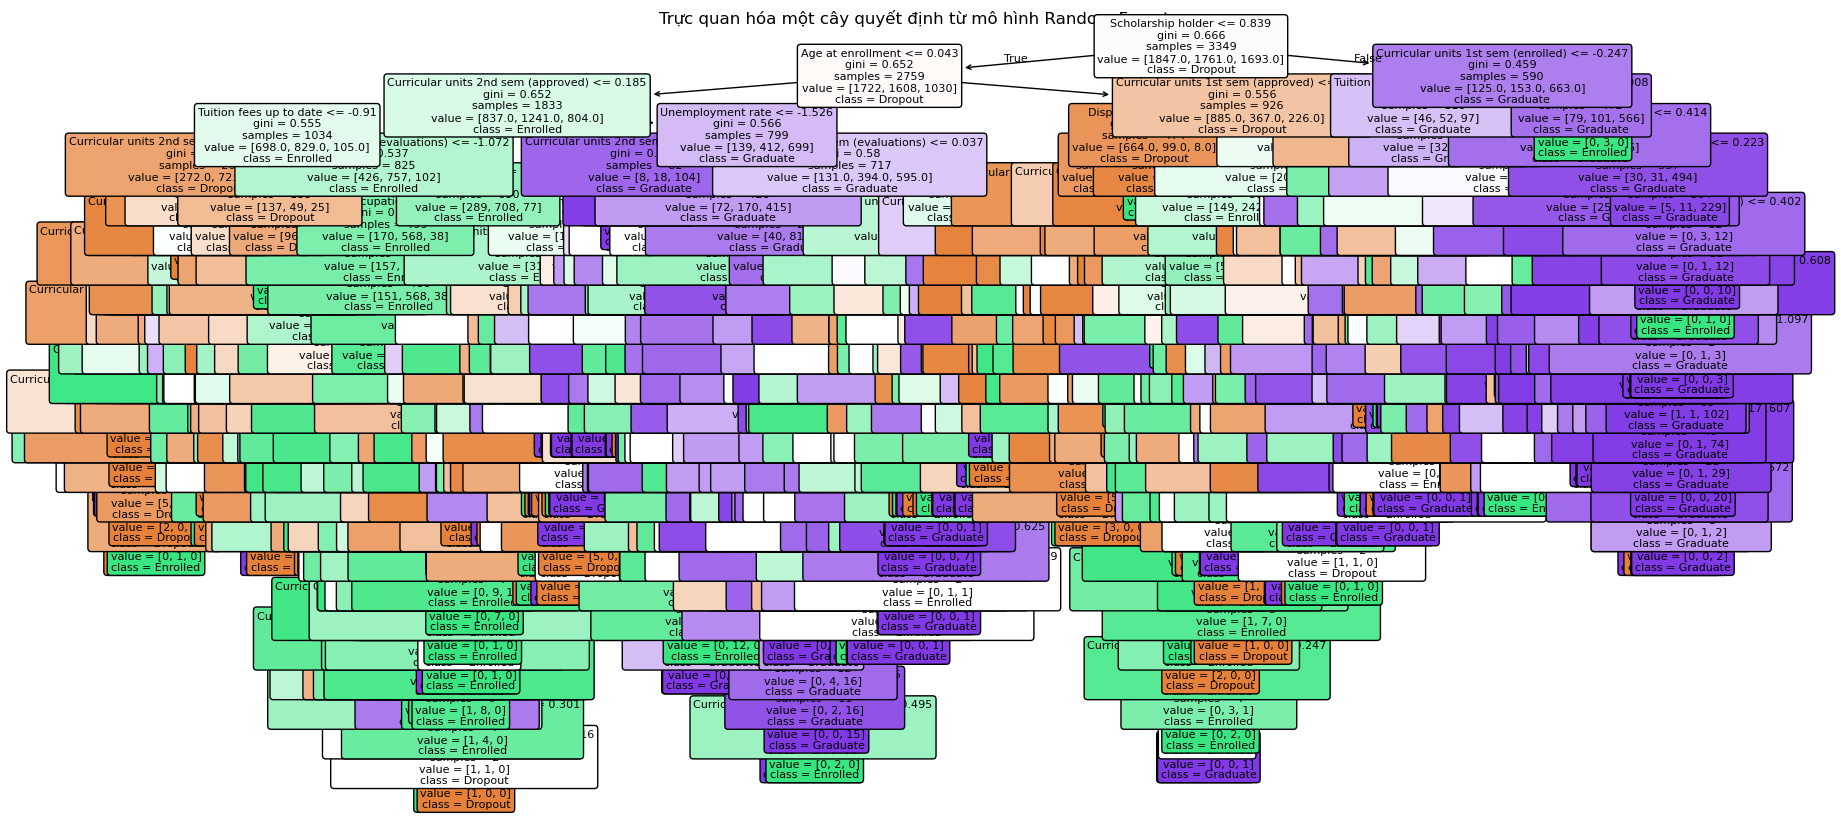

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# 1. Visualize Feature Importance
# Extract feature importance from the best model
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to visualize feature importance
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
plt.title('Feature Importance in the Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 2. Visualize a Single Tree from the Random Forest
# Extract a single tree from the Random Forest and visualize it
plt.figure(figsize=(20, 10))
plot_tree(
    best_pipeline.named_steps['classifier'].estimators_[0],
    filled=True,
    feature_names=X.columns,
    class_names=['Dropout', 'Enrolled', 'Graduate'],
    rounded=True,
    fontsize=8
)
plt.title('Visualization of a Decision Tree from the Random Forest Model')
plt.show()